In [1]:

import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    roc_auc_score,
    RocCurveDisplay
)
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

import matplotlib.pyplot as plt
import joblib


In [7]:
# Load dataset
data_path = "loan_approval_data.csv"  # change this path if needed
df = pd.read_csv(data_path)
df.head()


,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP00000,Male,Yes,0,Graduate,No,3806,2124,140,360,0.0,Semiurban,Y
1,LP00001,Female,Yes,0,Not Graduate,No,1500,907,62,360,1.0,Semiurban,Y
2,LP00002,Female,No,2,Graduate,No,4175,4622,164,360,1.0,Rural,Y
3,LP00003,Male,No,0,Graduate,No,6826,3560,181,300,1.0,Semiurban,Y
4,LP00004,Male,No,0,Graduate,Yes,6075,890,109,360,1.0,Urban,Y


In [8]:
# Dataset info
print("Shape:", df.shape)
print("\nColumns:", df.columns.tolist())
print("\nMissing values per column:\n", df.isna().sum())

df.describe(include="all").T.head(15)


Shape: (1000, 13)

Columns: ['Loan_ID', 'Gender', 'Married', 'Dependents', 'Education', 'Self_Employed', 'ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'Loan_Amount_Term', 'Credit_History', 'Property_Area', 'Loan_Status']

Missing values per column:
 Loan_ID              0
Gender               0
Married              0
Dependents           0
Education            0
Self_Employed        0
ApplicantIncome      0
CoapplicantIncome    0
LoanAmount           0
Loan_Amount_Term     0
Credit_History       0
Property_Area        0
Loan_Status          0
dtype: int64


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Loan_ID,1000,1000,LP00999,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Gender,1000,2,Male,712,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Married,1000,2,Yes,570,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Dependents,1000,4,0,594,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Education,1000,2,Graduate,719,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Self_Employed,1000,2,No,847,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ApplicantIncome,1000.0,NaN,NaN,NaN,4946.189,1889.82378,1500.0,3634.5,4975.5,6266.25,11304.0
CoapplicantIncome,1000.0,NaN,NaN,NaN,1993.002,1392.491836,0.0,947.75,1911.0,2915.0,6669.0
LoanAmount,1000.0,NaN,NaN,NaN,138.267,50.798329,20.0,102.0,137.0,174.0,316.0
Loan_Amount_Term,1000.0,NaN,NaN,NaN,314.46,66.49308,180.0,300.0,300.0,360.0,480.0


In [9]:

# Define features and target
X = df.drop(columns=["Loan_ID", "Loan_Status"])
y = (df["Loan_Status"] == "Y").astype(int)

categorical_cols = X.select_dtypes(include=["object"]).columns.tolist()
numeric_cols = X.select_dtypes(exclude=["object"]).columns.tolist()

print("Categorical columns:", categorical_cols)
print("Numeric columns:", numeric_cols)

# Preprocess: OneHotEncode categoricals, pass-through numeric
categorical_transformer = OneHotEncoder(handle_unknown="ignore")

preprocessor = ColumnTransformer(
    transformers=[
        ("cat", categorical_transformer, categorical_cols),
    ],
    remainder="passthrough"
)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

X_train.shape, X_test.shape


Categorical columns: ['Gender', 'Married', 'Dependents', 'Education', 'Self_Employed', 'Property_Area']
Numeric columns: ['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'Loan_Amount_Term', 'Credit_History']


((800, 11), (200, 11))

In [10]:

# Decision Tree pipeline
dt_clf = DecisionTreeClassifier(
    max_depth=5,
    min_samples_split=20,
    min_samples_leaf=10,
    random_state=42
)

dt_pipeline = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("model", dt_clf)
])

dt_pipeline.fit(X_train, y_train)

y_pred_dt = dt_pipeline.predict(X_test)
y_proba_dt = dt_pipeline.predict_proba(X_test)[:, 1]

print("Decision Tree Accuracy:", accuracy_score(y_test, y_pred_dt))
print("\nDecision Tree Classification Report:\n", classification_report(y_test, y_pred_dt))

cm_dt = confusion_matrix(y_test, y_pred_dt)
print("\nDecision Tree Confusion Matrix:\n", cm_dt)

try:
    auc_dt = roc_auc_score(y_test, y_proba_dt)
    print("Decision Tree ROC-AUC:", auc_dt)
except Exception as e:
    print("Could not compute ROC-AUC:", e)


Decision Tree Accuracy: 0.71

Decision Tree Classification Report:
               precision    recall  f1-score   support

           0       0.41      0.13      0.19        55
           1       0.74      0.93      0.82       145

    accuracy                           0.71       200
   macro avg       0.57      0.53      0.51       200
weighted avg       0.65      0.71      0.65       200


Decision Tree Confusion Matrix:
 [[  7  48]
 [ 10 135]]
Decision Tree ROC-AUC: 0.5341692789968652


In [11]:

# Random Forest pipeline
rf_clf = RandomForestClassifier(
    n_estimators=200,
    max_depth=None,
    min_samples_split=10,
    min_samples_leaf=5,
    random_state=42,
    n_jobs=-1
)

rf_pipeline = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("model", rf_clf)
])

rf_pipeline.fit(X_train, y_train)

y_pred_rf = rf_pipeline.predict(X_test)
y_proba_rf = rf_pipeline.predict_proba(X_test)[:, 1]

print("Random Forest Accuracy:", accuracy_score(y_test, y_pred_rf))
print("\nRandom Forest Classification Report:\n", classification_report(y_test, y_pred_rf))

cm_rf = confusion_matrix(y_test, y_pred_rf)
print("\nRandom Forest Confusion Matrix:\n", cm_rf)

auc_rf = roc_auc_score(y_test, y_proba_rf)
print("Random Forest ROC-AUC:", auc_rf)


Random Forest Accuracy: 0.725

Random Forest Classification Report:
               precision    recall  f1-score   support

           0       0.50      0.04      0.07        55
           1       0.73      0.99      0.84       145

    accuracy                           0.72       200
   macro avg       0.61      0.51      0.45       200
weighted avg       0.67      0.72      0.63       200


Random Forest Confusion Matrix:
 [[  2  53]
 [  2 143]]
Random Forest ROC-AUC: 0.6018808777429465


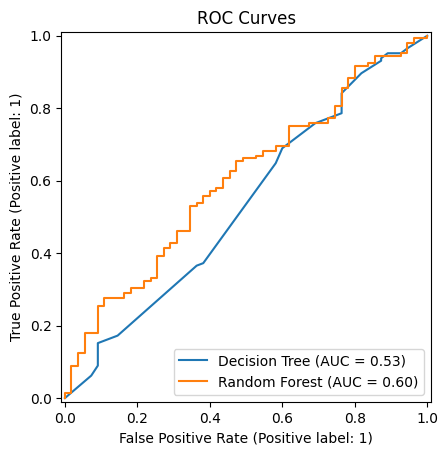

In [12]:
# Compare ROC curves
fig, ax = plt.subplots()

RocCurveDisplay.from_predictions(y_test, y_proba_dt, name="Decision Tree", ax=ax)
RocCurveDisplay.from_predictions(y_test, y_proba_rf, name="Random Forest", ax=ax)

ax.set_title("ROC Curves")
plt.show()


In [13]:
# Inspect feature importance from Random Forest
# Need to get feature names after one-hot encoding
ohe = rf_pipeline.named_steps["preprocess"].named_transformers_["cat"]
ohe_features = ohe.get_feature_names_out(categorical_cols)

feature_names = list(ohe_features) + numeric_cols
importances = rf_pipeline.named_steps["model"].feature_importances_

feat_imp = pd.DataFrame({
    "feature": feature_names,
    "importance": importances
}).sort_values("importance", ascending=False)

feat_imp.head(15)


,feature,importance
15,ApplicantIncome,0.202777
17,LoanAmount,0.185119
16,CoapplicantIncome,0.182128
19,Credit_History,0.075075
18,Loan_Amount_Term,0.058163
2,Married_No,0.029514
8,Education_Graduate,0.029245
3,Married_Yes,0.028838
13,Property_Area_Semiurban,0.027057
4,Dependents_0,0.022702


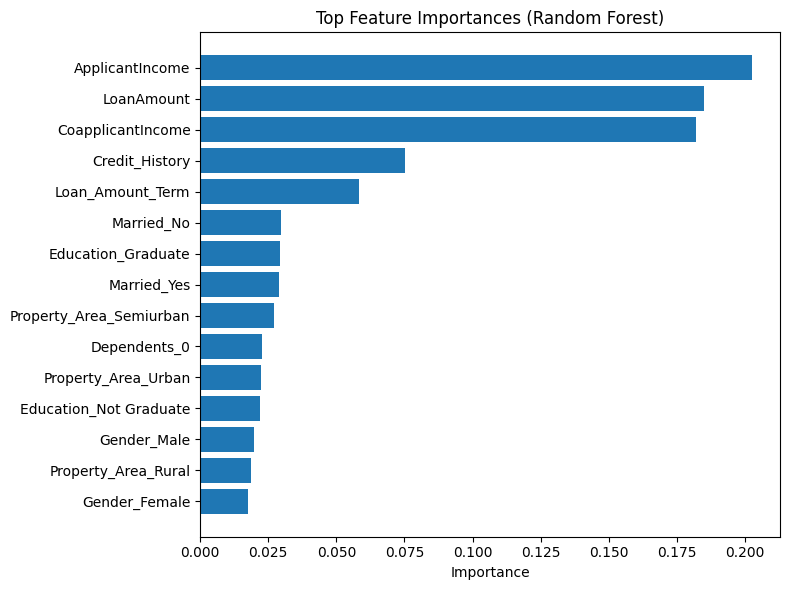

In [14]:
# Plot top 15 feature importances
top_k = 15
fi_top = feat_imp.head(top_k)[::-1]  # reverse for better plotting

fig, ax = plt.subplots(figsize=(8, 6))
ax.barh(fi_top["feature"], fi_top["importance"])
ax.set_xlabel("Importance")
ax.set_title("Top Feature Importances (Random Forest)")
plt.tight_layout()
plt.show()


In [15]:
# Simple fairness check: approval rate by Gender and Married status
def approval_rate(group_col):
    return df.groupby(group_col)["Loan_Status"].apply(lambda x: (x == "Y").mean())

print("Approval rate by Gender:")
print(approval_rate("Gender"))
print("\nApproval rate by Married:")
print(approval_rate("Married"))


Approval rate by Gender:
Gender
Female    0.736111
Male      0.720506
Name: Loan_Status, dtype: float64

Approval rate by Married:
Married
No     0.683721
Yes    0.756140
Name: Loan_Status, dtype: float64


In [16]:
# Save the trained Random Forest pipeline
model_path = "loan_approval_rf_model.pkl"
joblib.dump(rf_pipeline, model_path)
model_path


'loan_approval_rf_model.pkl'